# Data Analysis

This data analysis is for: Toxic Comment Classification Challenge compeition in Kaggle

URL : https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

Data files required can be downloaded from here: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

Download and save the data in ./data/ folder relative to this Jupyter notebook

## Numerical Analysis

1. Read ./data/train.csv file
2. Counts no. of training data per class
3. A single comment can belong to multiple class


In [1]:
import csv

# labels provided with the data set
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# non_toxic is label for comments belonging to none of the toxic_labels
labels_count = {'toxic' : 0,
                'severe_toxic' : 0,
                'obscene' : 0,
                'threat' : 0,
                'insult' : 0,
                'identity_hate' : 0,
                'non_toxic' : 0}

# read the CSV file
with open('./data/train.csv') as train_file:
    reader = csv.DictReader(train_file)
    total_row = 0
    for row in reader:
        total_row += 1
        is_none = True
        for label in toxic_labels:
            if(row[label] == '1'):
                labels_count[label] += 1
                is_none = False
        if(is_none):
            labels_count['non_toxic'] += 1
    print(labels_count)
    print(total_row)

{'toxic': 15294, 'severe_toxic': 1595, 'obscene': 8449, 'threat': 478, 'insult': 7877, 'identity_hate': 1405, 'non_toxic': 143346}
159571


In [2]:
import matplotlib.pyplot as plt

plt.xticks(rotation=90)
plt.bar(labels_count.keys(), labels_count.values(), 1/1.5, color='b')


<BarContainer object of 7 artists>

### Observations:
From above analysis we see that:
1. Total no. of data (training & validation) = 159,571
2. Total non-toxic comments = 143,346 (~ 89.83%)
3. Rest 10.17% of commets has one of the toxic label
4. Some of labels like threat, identity_hate, severe_toxic has very less samples compared to other labels

So data per class is highly imbalanced

## Language feature analysis

1. Understanding token (split comments into group of words) based features
2. Tokens histogram

In [3]:
texts = []
labels = []
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
toxic_labels_id_map = {
    'non_toxic' : 0,
    'toxic' : 1,
    'severe_toxic' : 2,
    'obscene' : 3,
    'threat' : 4,
    'insult' : 5,
    'identity_hate' : 6
    }

num_rows_texts = 0
num_rows_labels = 0
with open('./data/train.csv') as train_file:
    reader = csv.DictReader(train_file)
    for row in reader:
        prev_row_count = num_rows_labels
        num_rows_texts += 1
        texts.append(row['comment_text'])
        is_none = True
        # check for labels other than toxic (1st label)
        for label in toxic_labels[1:]:
            if(row[label] == '1'):
                num_rows_labels += 1
                labels.append(toxic_labels_id_map[label])
                is_none = False
                break # a comments can have multiple labels but for now just take the 1st label <-- need to fix it
        if(is_none):
            num_rows_labels += 1
            # finally check if it is toxic or non-toxic
            if(row['toxic'] == '1'):
                labels.append(toxic_labels_id_map['toxic'])
            else:
                labels.append(toxic_labels_id_map['non_toxic'])
        if((num_rows_texts - num_rows_labels) < 0):
            print(row)
            break;

print(num_rows_texts)
print(num_rows_labels)

159571
159571


In [4]:
print('labels size:', len(labels))
labels[1:10]

labels size: 159571


[0, 0, 0, 0, 0, 2, 0, 0, 0]

### encoding the data: 
as it is multi class classification problem, the label need to be encoded into one hot encoding layer

In [5]:
from keras.utils.np_utils import to_categorical
one_hot_labels = to_categorical(labels)

Using TensorFlow backend.


In [6]:
print(len(one_hot_labels))
print(one_hot_labels[6])

159571
[0. 0. 1. 0. 0. 0. 0.]


# Tokenizing the data

Splitting the comments in to tokens, later used to create word vectors

In [7]:
from keras.preprocessing.text import Tokenizer

max_words = 10000 # consider only the tops 10,000 words in dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokes.' % len(word_index))


Found 210337 unique tokes.


### pad/truncate all comments to a fixed length
ToDo: do this padding per batch

In [8]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 100 # cuts of comments after 100 words
data = pad_sequences(sequences, maxlen=maxlen)
one_hot_labels = np.asarray(one_hot_labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', one_hot_labels.shape)

Shape of data tensor: (159571, 100)
Shape of label tensor: (159571, 7)


## Split Data
#### Split the data into training data and validation data
#### Data can be shuffled (optional)

In [9]:
training_samples = 120000 # trains on 120,000 samples
validation_samples = 39571 # validates on 39,571 samples (rest)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
one_hot_labels = one_hot_labels[indices]
one_hot_labels = one_hot_labels[indices]

x_train = data[:training_samples]
y_train = one_hot_labels[:training_samples]

x_val = data[training_samples : training_samples + validation_samples]
y_val = one_hot_labels[training_samples : training_samples + validation_samples]

### GloVe (Global Vector) Word Embedding setup
download the glove precomputed imbedding from: https://nlp.stanford.edu/projects/glove
unzip it
it contains: 100 dimensional embedding vectors for 400,000 words from 2014 English Wikipedia

### preprocessing the embedding
#### Parsing the GloVe word-embedding file

In [12]:
import os

glove_dir = './data/glove/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Preparing the GloVe word-embedding matrix

1. Define embedding matrix dimension = embedding_dim (100) x max_words (10000 : defined above)
2. Iterated the word_idex and use top max_words to populated the embedding matrix using glove embedding_index

one can play with above params

In [13]:
embedding_dim = 100 # as we are using 100 dimensional glove index

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Defining a Model

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

model = Sequential()
# embedding layer
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# RNN layer (LSTM)
model.add(LSTM(32))
# output layer (7 classes)
model.add(Dense(7, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 1,017,255
Trainable params: 1,017,255
Non-trainable params: 0
_________________________________________________________________


### Loading the GloVe embeddings in the model

In [15]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### Training and evaluating the model

In [16]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')


Train on 120000 samples, validate on 39571 samples
Epoch 1/10
120000/120000 [==============================] - 348s 3ms/step - loss: 0.1161 - acc: 0.9705 - val_loss: 0.1134 - val_acc: 0.9710
Epoch 2/10
120000/120000 [==============================] - 341s 3ms/step - loss: 0.1141 - acc: 0.9709 - val_loss: 0.1140 - val_acc: 0.9710
Epoch 3/10
120000/120000 [==============================] - 343s 3ms/step - loss: 0.1140 - acc: 0.9709 - val_loss: 0.1142 - val_acc: 0.9710
Epoch 4/10
120000/120000 [==============================] - 338s 3ms/step - loss: 0.1142 - acc: 0.9709 - val_loss: 0.1198 - val_acc: 0.9710
Epoch 5/10
120000/120000 [==============================] - 335s 3ms/step - loss: 0.1145 - acc: 0.9709 - val_loss: 0.1141 - val_acc: 0.9710
Epoch 6/10
120000/120000 [==============================] - 334s 3ms/step - loss: 0.1145 - acc: 0.9709 - val_loss: 0.1157 - val_acc: 0.9710
Epoch 7/10
120000/120000 [==============================] - 333s 3ms/step - loss: 0.1151 - acc: 0.9709 - val_

### Plotting the training results

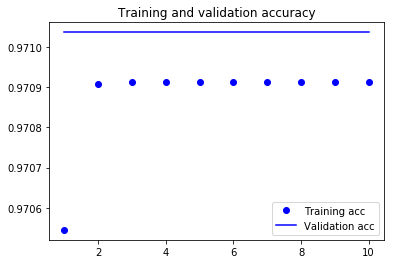

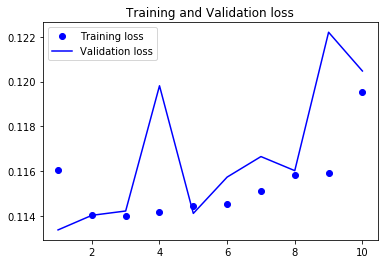

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


## Testing the model on test data

#### Tokenizing the data of the test data set

In [18]:
test_texts = []
test_labels = []
test_id = []

with open('./data/test.csv') as test_file:
    reader = csv.DictReader(test_file)
    for row in reader:
        test_texts.append(row['comment_text'])
        test_id.append(row['id'])

test_sequences = tokenizer.texts_to_sequences(test_texts)
x_test = pad_sequences(test_sequences, maxlen=maxlen)


In [19]:
test_labels = model.predict(x_test)

In [20]:
print(test_labels[:10])

[[8.99321735e-01 3.44238803e-02 7.99907744e-03 4.70137857e-02
  1.09596422e-05 9.88907274e-03 1.46325343e-04]
 [8.92793179e-01 3.85972336e-02 6.66554924e-03 4.34732027e-02
  1.15201565e-05 8.00725818e-03 1.05142033e-04]
 [8.81754279e-01 5.05931787e-02 1.25361867e-02 5.89744784e-02
  1.38426249e-05 1.49802594e-02 1.72158383e-04]
 [8.80268991e-01 5.83361462e-02 1.66629702e-02 7.10905120e-02
  7.72558051e-05 1.63404122e-02 6.02421002e-04]
 [8.87121439e-01 4.48487215e-02 1.12149371e-02 5.68175018e-02
  1.30675780e-05 1.23092998e-02 1.72166576e-04]
 [8.89781415e-01 4.16405313e-02 3.69876134e-03 4.41988744e-02
  1.61593252e-05 6.38197409e-03 8.25928728e-05]
 [8.91499639e-01 4.38223630e-02 8.59748758e-03 5.05084768e-02
  2.88539813e-05 8.24808795e-03 2.24820076e-04]
 [9.22545254e-01 1.77938603e-02 1.55059528e-03 2.49822717e-02
  2.15090108e-06 1.35168969e-03 1.37123779e-05]
 [8.93899441e-01 4.01023366e-02 9.90001298e-03 5.30185103e-02
  1.79393264e-05 1.14744371e-02 2.10716622e-04]
 [9.028617

In [21]:
print(test_labels.shape)
print(len(test_texts))

(153164, 7)
153164


### save the test out in file

In [22]:
# same the labels only as csv
np.savetxt('./test_labels_out.csv', test_labels, delimiter=',', fmt='%f')

In [23]:
# save the test labels with id
test_pred_out = []
with open('test-result.csv', 'w') as f:
    f.write("id,toxic,severe_toxic,obscene,threat,insult,identity_hate\n")
    for i in range(0, len(test_id)):
        #print(i)
        f.write(test_id[i])
        f.write(',')
        #generate an array with strings
        x_arrstr = np.char.mod('%f', test_labels[i, 1:])
        #combine to a string
        x_str = ",".join(x_arrstr)
        f.write(x_str)#,0:])#.tolist))
        f.write('\n')